In [1]:
import os
os.chdir('../src')
import numpy as np
np.set_printoptions(precision=2)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from directed_gradient import DirectedGradient
from test_optims import sgd_step
import test_fn as test_fn
from terminaltables import DoubleTable as Table
import torch as t

In [23]:
dim = 2
g_std = 0.0

num_epochs = 20
log_int = 1
final_table = True

visualize = dim == 2
xlim = 3.0
xc = 2

ylim = 3.0
yc = 2
delta = 0.25

In [24]:
lr = {
    'booth': 1e-2,
    'himmelblau': 1e-3,
    'square': 1e-1,
    'rastrigin': 1e-4,
    'rosenbrock': 1e-4,
}

init = {
    'booth': 4.5,
    'himmelblau': 4.5,
    'square': 4.5,
    'rastrigin': 1.5,
    'rosenbrock': 2.0,
}

fn = {
    'booth': test_fn.booth,
    'himmelblau': test_fn.himmelblau,
    'square': test_fn.square,
    'rastrigin': test_fn.rastrigin,
    'rosenbrock': test_fn.rosenbrock
}

In [25]:
tmp = [t.tensor([2, 2], dtype=t.float)]
table = [['func', 'output']]
for _, f in fn.items():
    table.append([_, '{:.8}'.format(f(tmp).item())])
table = Table(table, 'Test')
print(table.table)

╔Test════════╦═══════════╗
║ func       ║ output    ║
╠════════════╬═══════════╣
║ booth      ║ 2.0       ║
║ himmelblau ║ 26.0      ║
║ square     ║ 7.9999995 ║
║ rastrigin  ║ 8.0       ║
║ rosenbrock ║ 401.0     ║
╚════════════╩═══════════╝


--------------------------------------------------------------------------------
Noise Added:  0.0
--------------------------------------------------------------------------------


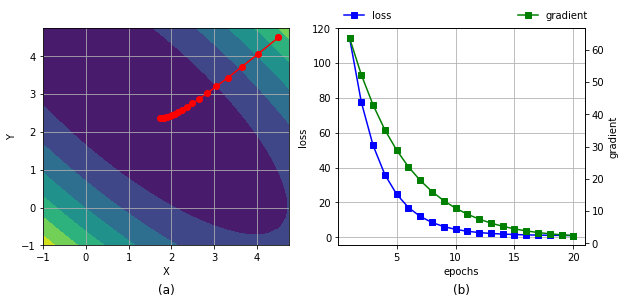

╔booth═════════════╦═══════════════╦══════════╗
║ ep ║ pt          ║ grad          ║ fn_val   ║
╠════╬═════════════╬═══════════════╬══════════╣
║ 20 ║ [1.74 2.38] ║ [ 2.4  -0.33] ║ 0.987871 ║
╚════╩═════════════╩═══════════════╩══════════╝


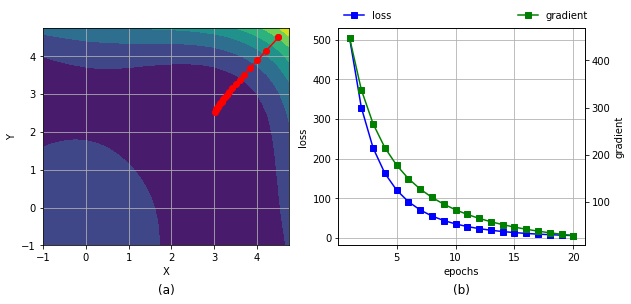

╔himmelblau════════╦═══════════════╦══════════╗
║ ep ║ pt          ║ grad          ║ fn_val   ║
╠════╬═════════════╬═══════════════╬══════════╣
║ 20 ║ [3.02 2.54] ║ [12.77 26.47] ║ 6.553267 ║
╚════╩═════════════╩═══════════════╩══════════╝


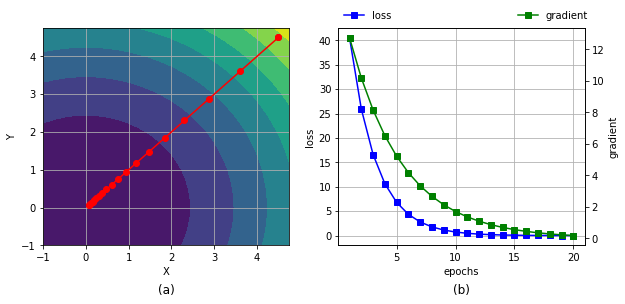

╔square════════════╦═════════════╦══════════╗
║ ep ║ pt          ║ grad        ║ fn_val   ║
╠════╬═════════════╬═════════════╬══════════╣
║ 20 ║ [0.06 0.06] ║ [0.13 0.13] ║ 0.008412 ║
╚════╩═════════════╩═════════════╩══════════╝


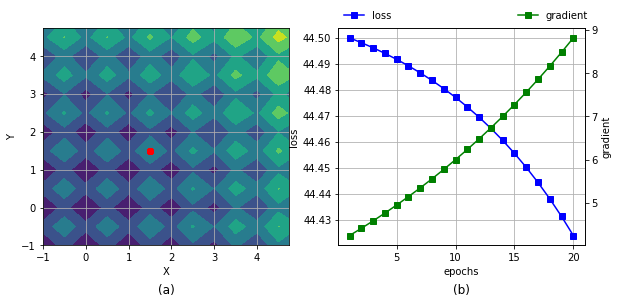

╔rastrigin═════════╦═════════════╦═══════════╗
║ ep ║ pt          ║ grad        ║ fn_val    ║
╠════╬═════════════╬═════════════╬═══════════╣
║ 20 ║ [1.49 1.49] ║ [6.24 6.24] ║ 44.423866 ║
╚════╩═════════════╩═════════════╩═══════════╝


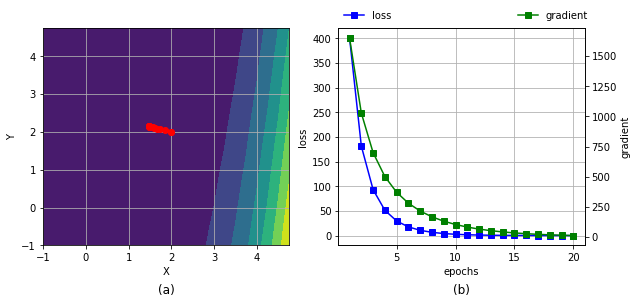

╔rosenbrock════════╦═══════════════╦══════════╗
║ ep ║ pt          ║ grad          ║ fn_val   ║
╠════╬═════════════╬═══════════════╬══════════╣
║ 20 ║ [1.47 2.15] ║ [10.66 -3.3 ] ║ 0.249704 ║
╚════╩═════════════╩═══════════════╩══════════╝


In [26]:
print('-'*80)
print("Noise Added: ", g_std)
print('-'*80)
for fn_name in lr:
    params = [t.tensor([init[fn_name] for _ in range(dim)], dtype=t.float, requires_grad=True)]
    opt = DirectedGradient(params, lr=lr[fn_name])

    table = [['ep', 'pt', 'grad', 'fn_val']]
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = ax2.twinx()

    for epoch in range(num_epochs):
        loss = fn[fn_name](params)
        opt.zero_grad()
        loss.backward()
        if (epoch+1)%log_int == 0:
            table.append([
                epoch+1, 
                params[0].clone().detach().numpy(), 
                [_.grad for _ in params][0].clone().numpy(), 
                '{:.6f}'.format(loss.item())
            ])
        sgd_step(params, opt, lr[fn_name], g_std)
    x = np.arange(xc-xlim, xc+xlim, delta)
    y = np.arange(yc-ylim, yc+ylim, delta)
    X, Y = np.meshgrid(x, y)
    size = X.shape
    Z = np.array([fn[fn_name]([t.tensor(_)]).item() for _ in zip(X.flatten(), Y.flatten())]).reshape(size)
    CS = ax1.contourf(X, Y, Z)
    ax1.set_title('(a)', y=-0.25)
    x, y = [], []
    for row in table[1:]:
        pt = row[1]
        x.append(pt[0].item())
        y.append(pt[1].item())
    ax1.plot([init[fn_name]] + x, [init[fn_name]] + y, 'ro-')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.grid()


    data = [(_[0], t.norm(t.tensor(_[2])).item(), float(_[3])) for _ in table[1:]]
    x, y2, y1 = zip(*data)
    ax2.plot(x, y1, 'bs-', label='loss')
    ax3.plot(x, y2, 'gs-', label='gradient')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('loss')
    ax3.set_ylabel('gradient')
    ax2.set_title('(b)', y=-0.25)
    ax2.grid()
    ax2.legend(loc='upper right', bbox_to_anchor=(-1, 1.1, 1.25, 0.02), frameon=False)
    ax3.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.1, 1.25, 0.02), frameon=False)
    plt.show()

    if final_table:
        table = [table[0], table[-1]]
    table = Table(table, fn_name)
    table.justify_columns[0] = 'right'
    print(table.table)
        